# This is Movie Classification Team 11's EDA Notebook

### Team Members:
Andrew Lund, Nicholas Morgam, Amay Umradia, Charles Webb

The purpose of this notebook is to explore the dataset we have built with TMDB and IMDB movie data on 1000 movies. We will primarily be exploring plot and genre information since that is the primary focus of this project: Predicting genres from plots. The analysis for these plots can be found in our Milestone 3 submission pdf located in this repository's 'submissions' directory.

In [31]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tmdbsimple as tmdb
import requests
import pandas as pd
import time
import numpy as np
from ast import literal_eval
from collections import Counter
sns.set_context('talk')
sns.set_style('ticks')


#### Get TMDB genre labels for reference

In [32]:
key = open('key.txt','r').read()
payload = '{}'
url = "https://api.themoviedb.org/3/genre/movie/list?api_key={0}&language=en-US&page={1}".format(key, str(1))
response = requests.request("GET", url, data=payload).json()

genreDict = dict(zip([i['id'] for i in response['genres']],
                     [i['name'] for i in response['genres']]))
genreDict

{12: 'Adventure',
 14: 'Fantasy',
 16: 'Animation',
 18: 'Drama',
 27: 'Horror',
 28: 'Action',
 35: 'Comedy',
 36: 'History',
 37: 'Western',
 53: 'Thriller',
 80: 'Crime',
 99: 'Documentary',
 878: 'Science Fiction',
 9648: 'Mystery',
 10402: 'Music',
 10749: 'Romance',
 10751: 'Family',
 10752: 'War',
 10770: 'TV Movie'}

#### Read in our scraped movie data

In [33]:
#list of columns in our 'movies.csv' that need to be read in using literal_eval
#to ensure they are represented as vectors rather than strings
converterList = ['imdb_genres', 'tmdb_genres', 'binary_tmdb', 'binary_imdb',
               'imdb_w2v_plot', 'tmdb_w2v_plot', 'tmdb_bow_plot', 'imdb_bow_plot']

converterDict = {column: literal_eval for column in converterList}

movies = pd.read_csv('data/movies.csv', encoding='utf-8',
                     converters=converterDict)

movies.release_date = pd.to_datetime(movies.release_date)
movies.head()

,tmdb_id,imdb_id,tmdb_genres,imdb_genres,binary_tmdb,binary_imdb,tmdb_plot,imdb_plot,popularity,release_date,title,vote_average,vote_count,tmdb_clean_plot,imdb_clean_plot,tmdb_w2v_plot,imdb_w2v_plot,tmdb_bow_plot,imdb_bow_plot
0,278,tt0111161,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Framed in the 1940s for the double murder of h...,Chronicles the experiences of a formerly succe...,28.527767,1994-09-23,The Shawshank Redemption,8.5,9773,"['framed', '1940s', 'double', 'murder', 'wife'...","['chronicles', 'experiences', 'formerly', 'suc...","[0.014165705069899559, 0.035729147493839264, 0...","[0.004663567990064621, 0.09018586575984955, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,238,tt0068646,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","Spanning the years 1945 to 1955, a chronicle o...",When the aging head of a famous crime family d...,36.965452,1972-03-14,The Godfather,8.5,7394,"['spanning', 'years', '1945', '1955', 'chronic...","['aging', 'head', 'famous', 'crime', 'family',...","[-0.016820836812257767, 0.05966977775096893, -...","[-0.013326308690011501, 0.08134819567203522, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,424,tt0108052,"[18, 36, 10752]","[18, 36]","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",The true story of how businessman Oskar Schind...,Oskar Schindler is a vainglorious and greedy G...,19.945455,1993-11-29,Schindler's List,8.4,5518,"['true', 'story', 'businessman', 'oskar', 'sch...","['oskar', 'schindler', 'vainglorious', 'greedy...","[0.0758906751871109, 0.02254812978208065, 0.06...","[0.05338115245103836, 0.10281133651733398, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,240,tt0071562,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",In the continuing saga of the Corleone crime f...,The continuing saga of the Corleone crime fami...,30.191804,1974-12-20,The Godfather: Part II,8.4,4249,"['continuing', 'saga', 'corleone', 'crime', 'f...","['continuing', 'saga', 'corleone', 'crime', 'f...","[-0.05790800228714943, 0.07111673057079315, -0...","[-0.05151921883225441, 0.07896284759044647, -0...","[0.0, 0.0, 0.34648671489524274, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.324..."
4,452522,tt0278784,"[18, 9648]","[80, 18, 9648, 53]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...",Standalone version of the series pilot with an...,"When beautiful, young Laura Palmer is found br...",5.969249,1989-12-31,Twin Peaks,8.4,123,"['standalone', 'version', 'series', 'pilot', '...","['beautiful', 'young', 'laura', 'palmer', 'fou...","[-0.05888228118419647, -0.05345569923520088, -...","[0.0026558770332485437, 0.10140948742628098, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Print a movie title and its TMDB and IMDB plot for comparison

In [34]:
print('Title:\n', movies.title[12],
      '\n\nTMDB Plot:\n', movies.tmdb_plot[12], 
      '\n\nIMDB Plot:\n', movies.imdb_plot[12])

Title:
 Psycho 

TMDB Plot:
 When larcenous real estate clerk Marion Crane goes on the lam with a wad of cash and hopes of starting a new life, she ends up at the notorious Bates Motel, where manager Norman Bates cares for his housebound mother. The place seems quirky, but fine… until Marion decides to take a shower 

IMDB Plot:
 Phoenix officeworker Marion Crane is fed up with the way life has treated her. She has to meet her lover Sam in lunch breaks and they cannot get married because Sam has to give most of his money away in alimony. One Friday Marion is trusted to bank $40,000 by her employer. Seeing the opportunity to take the money and start a new life, Marion leaves town and heads towards Sam's California store. Tired after the long drive and caught in a storm, she gets off the main highway and pulls into The Bates Motel. The motel is managed by a quiet young man called Norman who seems to be dominated by his mother.::Col Needham 


### Distribution of Movie Ratings in Dataset

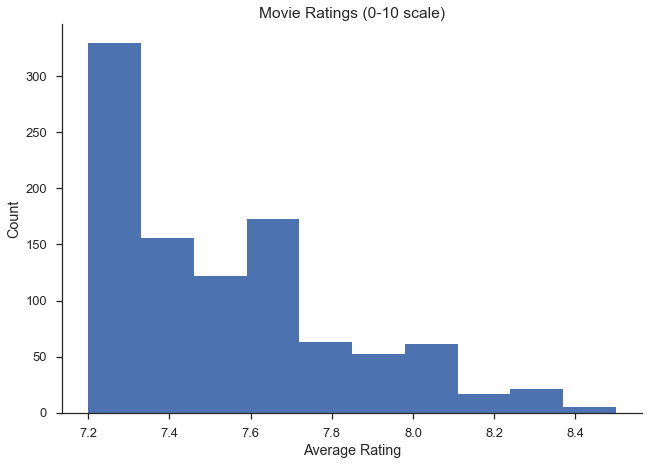

In [35]:
plt.hist(movies.vote_average)
plt.title('Movie Ratings (0-10 scale)')
plt.xlabel('Average Rating')
plt.ylabel('Count')
sns.despine()

### Total Counts of TMDB Genres in Dataset

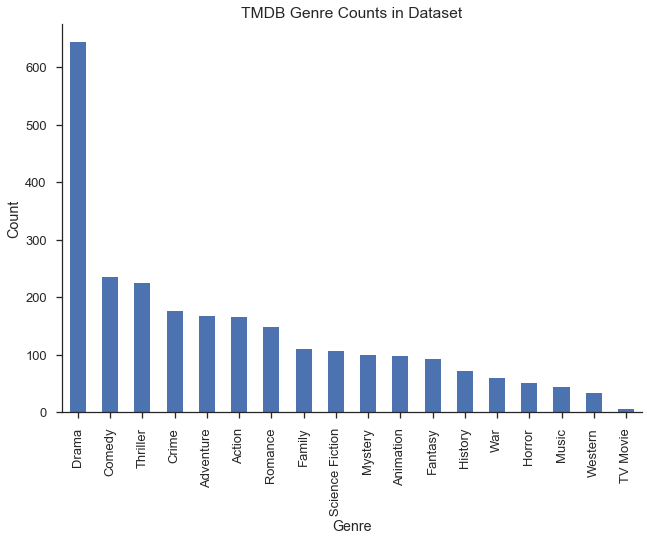

In [51]:
genre_list_ints = []
for sublist in list(movies.tmdb_genres):
    for item in sublist:
        genre_list_ints.append(item)

genre_list_strings = []
for genre in genre_list_ints:
    genre_list_strings.append(genreDict[genre])
    
genre_counts = Counter(genre_list_strings)
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index')
genre_df.sort_values(by = 0, ascending=False).plot(kind='bar', legend=False)
plt.title('TMDB Genre Counts in Dataset')
plt.ylabel('Count')
plt.xlabel('Genre')
sns.despine()

### Count by Movie of Total TMDB & IMDB Genre Labels in Dataset

Average TMDB Genres: 2.535
Average IMDB Genres: 2.831


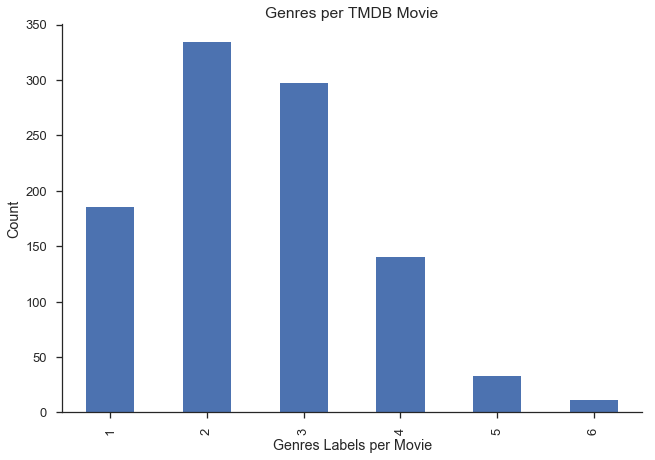

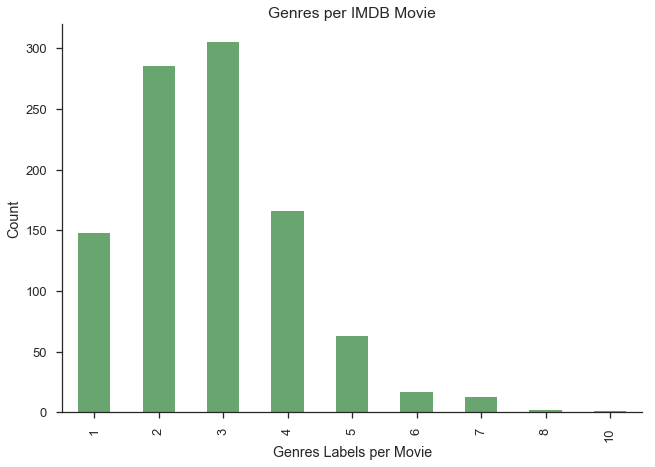

In [43]:
#count number of genres per movie
tmdb_num_genres_per_movie = [len(genres) for genres in movies.tmdb_genres]
imdb_num_genres_per_movie = [len(genres) for genres in movies.imdb_genres]

#collect counts and plot for both imdb and tmdb
tmdb_num_genre_counts = Counter(tmdb_num_genres_per_movie)
tmdb_genre_counts_df = pd.DataFrame.from_dict(tmdb_num_genre_counts, orient='index')
tmdb_genre_counts_df = tmdb_genre_counts_df.sort_index()
tmdb_genre_counts_df.plot(kind='bar', legend=False)
plt.title('Genres per TMDB Movie')
plt.xlabel('Genres Labels per Movie')
plt.ylabel('Count')
sns.despine()


imdb_num_genre_counts = Counter(imdb_num_genres_per_movie)
imdb_genre_counts_df = pd.DataFrame.from_dict(imdb_num_genre_counts, orient='index')
imdb_genre_counts_df = imdb_genre_counts_df.sort_index()
imdb_genre_counts_df.plot(kind='bar', legend=False, color='#69a56e')
plt.title('Genres per IMDB Movie')
plt.xlabel('Genres Labels per Movie')
plt.ylabel('Count')
sns.despine()

print('Average TMDB Genres:', np.mean(tmdb_num_genres_per_movie))
print('Average IMDB Genres:', np.mean(imdb_num_genres_per_movie))

### Counts of Movie Release Years in Dataset

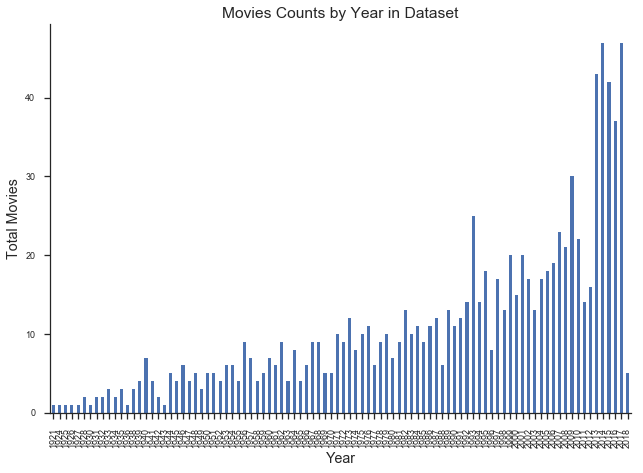

In [25]:
movie_years = [year.year for year in movies.release_date]
year_counts = Counter(movie_years)
year_df = pd.DataFrame.from_dict(year_counts, orient='index')
year_df.sort_index().plot(kind='bar', legend=False)
plt.title('Movies Counts by Year in Dataset')
plt.tick_params(labelsize=9)
plt.ylabel('Total Movies')
plt.xlabel('Year')
sns.despine()

### Distribution of TMDB & IMDB Plot Lengths

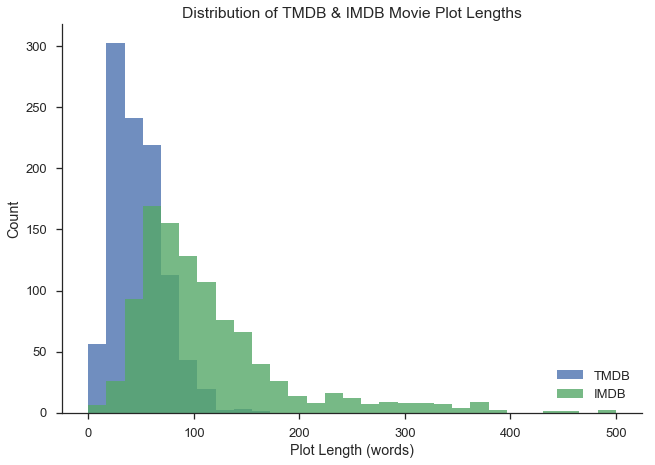

In [46]:
#tmdb lengths
tmdb_plot_lengths = []
for plot in movies.tmdb_plot:
    plot_length = len(plot.split())
    tmdb_plot_lengths.append(plot_length)
    
#imdb lengths
imdb_plot_lengths = []
for plot in movies.imdb_plot:
    plot_length = len(plot.split())
    imdb_plot_lengths.append(plot_length)
    
#plot tmdb lengths
bins = np.linspace(0, 500, 30)
plt.hist(tmdb_plot_lengths, bins, alpha = 0.8, label = 'TMDB')
plt.hist(imdb_plot_lengths, bins, alpha = 0.8, label = 'IMDB')
plt.xlabel('Plot Length (words)')
plt.ylabel('Count')
plt.title('Distribution of TMDB & IMDB Movie Plot Lengths')
plt.legend(loc='lower right')
sns.despine();

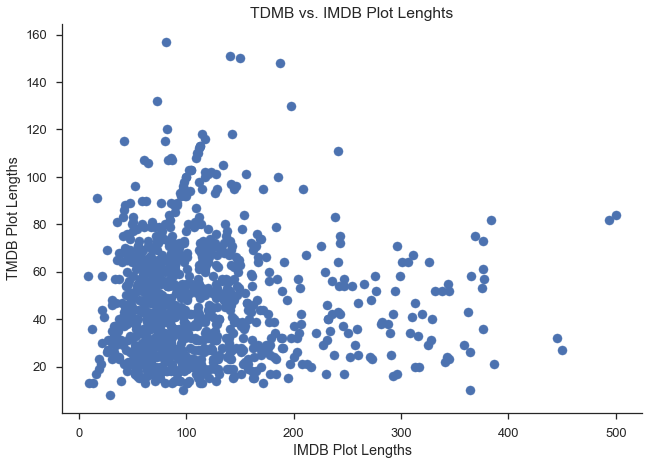

In [47]:
#scatter of TMDB vs IMDB plot lengths
plt.scatter(imdb_plot_lengths, tmdb_plot_lengths)
plt.title('TDMB vs. IMDB Plot Lenghts')
plt.xlabel('IMDB Plot Lengths')
plt.ylabel('TMDB Plot Lengths')
sns.despine();

#### More plot length metrics

In [48]:
print('Shortest and longest plots (words):')
print('TMDB: ', min(tmdb_plot_lengths),',', max(tmdb_plot_lengths))
print('Mean TMDB plot length:', np.mean(tmdb_plot_lengths))
print()
print('IMDB: ', min(imdb_plot_lengths),',', max(imdb_plot_lengths))
print('Mean IMDB plot length:', np.mean(imdb_plot_lengths))


Shortest and longest plots (words):
TMDB:  8 , 157
Mean TMDB plot length: 47.539

IMDB:  9 , 500
Mean IMDB plot length: 112.321


### Plot Lengths vs. Number of Genres per Movie

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


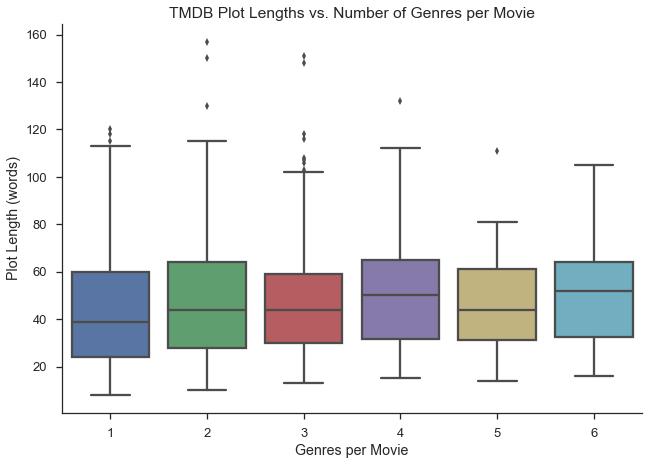

In [49]:
sns.boxplot(tmdb_num_genres_per_movie, tmdb_plot_lengths)
plt.title('TMDB Plot Lengths vs. Number of Genres per Movie')
plt.xlabel('Genres per Movie')
plt.ylabel('Plot Length (words)')
sns.despine()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


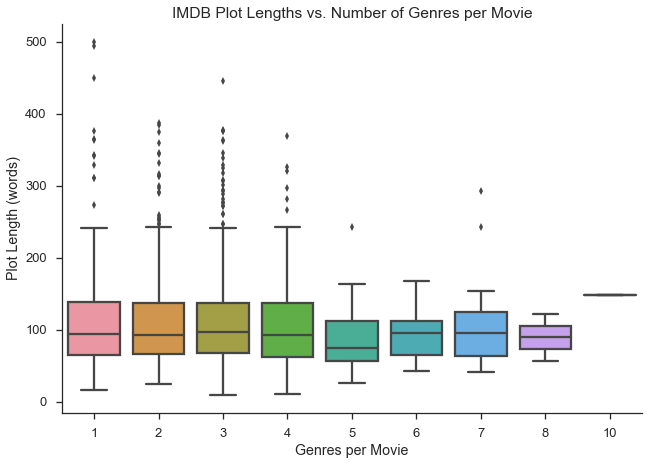

In [50]:
sns.boxplot(imdb_num_genres_per_movie, imdb_plot_lengths)
plt.title('IMDB Plot Lengths vs. Number of Genres per Movie')
plt.xlabel('Genres per Movie')
plt.ylabel('Plot Length (words)')
sns.despine()